## IDS576 - Team 3
#### 1) Training CIFAR Models:
- Standard
- Dropout
- Random Feature Nullification (RFN)

#### 2) Evaluate with FSGM Adversary Samples

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
%config IPCompleter.greedy = True
random_seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Import CIFAR dataset and prepare for training

In [4]:
import numpy as np
def get_train_data_stats(train_data):
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array\
    x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
    print(x.shape)
    # calculate the mean and std along the (0, 1) axes
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(train_mean, train_std)
    return train_mean, train_std

In [5]:
# load the training data for determination of mean and std
data_path = '~/IDS576/data'
train_data = datasets.CIFAR10(root=data_path, train=True, download=True)
train_mean, train_std = get_train_data_stats(train_data)
print(train_mean/255, train_std/255)

Files already downloaded and verified
(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [6]:
normalize = transforms.Normalize(
    mean=train_mean/255,
    std=train_std/255)

train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])
    
val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize])

In [7]:
# Download train and test data
data_path = '~/IDS576/data'
trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
valset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=val_transform)
testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Split train data in to train and validation data using torch dataset and utils.data modules

val_size = .2
n_train = len(trainset)

# get train set indices and split point based on val size
indices = list(range(n_train))
split = int(np.floor(val_size * n_train))

# shuffle trainset indices
np.random.seed(random_seed)
np.random.shuffle(indices)

# split train into train and val with shuffled indices at split point. 
train_idx, val_idx = indices[split:], indices[:split]

# Create train and val samplers based in split indices for use with DataLoader batch sampling
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
full_train_sampler = SubsetRandomSampler(indices)

batch_size = 128 # per paper
n_trn = n_train*(1-val_size)
batches = n_trn/batch_size

# CUDA settings
num_workers = 0 # allows preload of next batch, but greater than zero isn't recommended for cuda ops
pin_memory = True

train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

val_dl = DataLoader(
    valset, batch_size=batch_size, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

full_train_dl = DataLoader(
    trainset, batch_size=batch_size, sampler=full_train_sampler,
    num_workers=num_workers, pin_memory=pin_memory)

test_dl = DataLoader(
    testset, batch_size=batch_size,
    num_workers=num_workers, pin_memory=pin_memory)

def single_dl(xy, batch_size=1):
    return DataLoader(xy, batch_size=batch_size, num_workers=1, pin_memory=pin_memory)

In [9]:
classes = trainset.classes
classdict = {label: name for label, name in enumerate(classes)}
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Train models on CIFAR

In [10]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    correct = 0
    output = model(xb)
    _, preds = torch.max(output, 1)
    correct = torch.sum(preds == yb)
    acc = correct.double()/len(yb)
    loss = loss_func(output, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), acc   

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    mod = n_trn/(batch_size*20)
    running_corrects = 0
    val_accs = []
    val_losses = []
    for epoch in range(epochs):
        since = time.time()
        model.train()
        #i=0
        print(f'Epoch {epoch+1}/{epochs}: [', end='')
        for i, (xb, yb) in enumerate(train_dl):
            if not i % mod:
                print('*', end='')
            loss_batch(model, loss_func, xb, yb, opt)
            #i+=1
        print(']', end='')
        model.eval()
        print(' Val Loss: ', end='')
        with torch.no_grad():
            losses, nums, acc = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)
        
        # Save history
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'{val_loss:6.4f}, Val Acc: {val_acc:6.4f} ', end='')
        until = time.time()
        print(f'Elapsed (sec): {until-since:<5.1f}')
    return val_accs, val_losses

#### Define models from paper appendix

In [11]:
class CIFAR_Standard(nn.Module):
    
    def __init__(self):
        super(CIFAR_Standard, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return x

In [12]:
class CIFAR_Dropout(nn.Module):
    
    def __init__(self):
        super(CIFAR_Dropout, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 72, 3, padding=1)
        self.conv2b = nn.Conv2d(72, 72, 3, padding=1)
        self.fc1 = nn.Linear(72 * 8 * 8, 512)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 72 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x


In [17]:
class CIFAR_RFN(nn.Module):
    
    def __init__(self):
        super(CIFAR_RFN, self).__init__()
        self.conv1a = nn.Conv2d(3, 64, 3, padding=2)
        self.conv1b = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
                             
    def forward(self, x):
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool(F.relu(x))
        
        x = self.conv2a(x)
        x = self.conv2b(x)
        
        x = self.pool(F.relu(x))
        
        x = x.view(-1, 128 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

In [18]:
import torch.nn as nn
import torch
import numpy as np

class RFN(nn.Module):
    '''Wrapper class that takes any nn.Module based model and adds an RFN layer prior to all other layers.'''
    
    
    def __init__(self, model, mu=.1, sigma=.05, rfn_flag=True):
        super(RFN, self).__init__()
        self.model = model
        self.mu = mu
        self.sigma = sigma
        self.rfn_flag = rfn_flag
        self.shape_vals = None

    def forward(self, x):
        if self.rfn_flag:
            x = self.random_masks(x) * x
            x = self.model(x)
        else:
            x = self.model(x)
        return x
    
    
    def random_masks(self, x):
        # Calculate shape values for x
        self.shape_vals = x.size(), x[0].size(), x[0].nelement()

        # Create ones array of size (batch,channel,horiz,vert)
        masks = np.ones(self.shape_vals[0])

        # Create random masks for each sample in the batch
        for mask in masks:
            zero_cnt = np.absolute(int(np.ceil((self.sigma * np.random.randn() + self.mu) * self.shape_vals[2])))
            zero_idx = np.random.choice(self.shape_vals[2], zero_cnt, replace=False)
            mask.reshape(self.shape_vals[2])[zero_idx] = 0
            mask.reshape(self.shape_vals[1])
        return torch.tensor(masks, dtype=torch.float, device=device)

#### Train Standard, Dropout, and RFN models at 50 epochs each on trainset eval in validation set

In [102]:
# Create dictionary to store training history for all models
models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]

history = {}
for model_name in models.keys():
    history[model_name] = {}
    for mu in rfn_mu_vals:
        history[model_name][mu] = {}

In [105]:
# Train Standard, Dropout, and RFN CIFAR model using paper hyperparameters
# Train on train data, eval on validation data to determine epoch cutoff
# Here we use epochs = 50 as used in paper

models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epochs = 50

for model_name, model_instance in models.items():
    print()
    for mu in rfn_mu_vals:    
        # Set whether RFN will be used in training
        if mu == 0:
            rfn_flag = False
        else:
            rfn_flag = True
        
        # Standard and Dropout models don't need to be trained with RFN
        if model_name != 'RFN' and mu != 0:
            print(f'Skip {model_name} at mu={mu}')
            continue
            
        print(f'Training {model_name}: RFN={rfn_flag}, mu={mu}:')     
        model = model_instance
        model.to(device)
        rfn_wrapper = RFN(model, mu=mu, sigma=.05, rfn_flag=rfn_flag)
        rfn_wrapper.to(device)

        loss_func = nn.CrossEntropyLoss()
        opt = optim.Adam(model.parameters(), lr=0.001) # Opt and LR per paper
        
        # Save tuple of epoch val accuracy and val loss to history dict
        history[model_name][mu] = fit(epochs, rfn_wrapper, loss_func, opt, train_dl, val_dl)

        # Save model
        PATH = f'./models/CIFAR_{model_name}_{mu}.pth'
        torch.save(model.state_dict(), PATH)


Training Standard: RFN=False, mu=0:
Epoch 1/50: [***] Val Loss: 1.8839, Val Acc: 0.3514 Elapsed (sec): 18.4 
Epoch 2/50: [***] Val Loss: 1.6629, Val Acc: 0.4663 Elapsed (sec): 18.4 
Epoch 3/50: [***] Val Loss: 1.4916, Val Acc: 0.5257 Elapsed (sec): 18.6 
Epoch 4/50: [***] Val Loss: 1.5067, Val Acc: 0.5226 Elapsed (sec): 18.5 
Epoch 5/50: [***] Val Loss: 1.4942, Val Acc: 0.5346 Elapsed (sec): 18.5 
Epoch 6/50: [***] Val Loss: 1.5260, Val Acc: 0.5444 Elapsed (sec): 18.5 
Epoch 7/50: [***] Val Loss: 1.5872, Val Acc: 0.5335 Elapsed (sec): 18.5 
Epoch 8/50: [***] Val Loss: 1.5839, Val Acc: 0.5337 Elapsed (sec): 18.5 
Epoch 9/50: [***] Val Loss: 1.7194, Val Acc: 0.5340 Elapsed (sec): 18.5 
Epoch 10/50: [***] Val Loss: 1.7143, Val Acc: 0.5242 Elapsed (sec): 18.5 
Epoch 11/50: [***] Val Loss: 1.8073, Val Acc: 0.5234 Elapsed (sec): 18.4 
Epoch 12/50: [***] Val Loss: 1.8071, Val Acc: 0.5140 Elapsed (sec): 18.5 
Epoch 13/50: [***] Val Loss: 1.9126, Val Acc: 0.5189 Elapsed (sec): 18.4 
Epoch 14/5

In [106]:
import pickle
with open('./models/train50_cifar_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [107]:
with open('./models/train50_cifar_history.pkl', 'rb') as f:
    history = pickle.load(f)

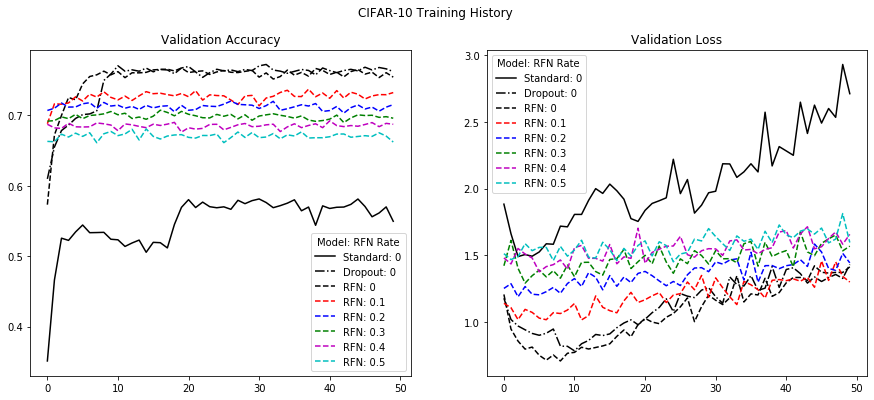

In [108]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']
linestyles = ['-', '-.', '--'] #Standard=solid, Dropout=dashdot, RFN=dash

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle('CIFAR-10 Training History')
ax[0].set_title('Validation Accuracy')
ax[1].set_title('Validation Loss')
for linestyle, model_name in zip(linestyles, models.keys()):
    for color, (mu, vals) in zip(colors, history[model_name].items()):
        try:
            acc, loss = vals
            ax[0].plot(range(len(acc)), acc, color+linestyle, label=f'{model_name}: {mu}')
            ax[1].plot(range(len(loss)), loss, color+linestyle, label=f'{model_name}: {mu}')
        except:
            continue
ax[0].legend(title='Model: RFN Rate')
ax[1].legend(title='Model: RFN Rate')

#### Train Standard, Dropout, and RFN models at 20 epochs each on full trainset eval on test set

In [109]:
# Create dictionary to store full train/ test history for all models
models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]

history = {}
for model_name in models.keys():
    history[model_name] = {}
    for mu in rfn_mu_vals:
        history[model_name][mu] = {}

In [111]:
# Train Standard, Dropout, and RFN CIFAR model using paper hyperparameters
# Train on full train data, eval on test data using epochs = 20


models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epochs = 20

for model_name, model_instance in models.items():
    print()
    for mu in rfn_mu_vals:    
        # Set whether RFN will be used in training
        if mu == 0:
            rfn_flag = False
        else:
            rfn_flag = True
        
        # Standard and Dropout models don't need to be trained with RFN
        if model_name != 'RFN' and mu != 0:
            print(f'Skip {model_name} at mu={mu}')
            continue
            
        print(f'Training {model_name}: RFN={rfn_flag}, mu={mu}:')     
        model = model_instance
        model.to(device)
        rfn_wrapper = RFN(model, mu=mu, sigma=.05, rfn_flag=rfn_flag)
        rfn_wrapper.to(device)

        loss_func = nn.CrossEntropyLoss()
        opt = optim.Adam(model.parameters(), lr=0.001) # Opt and LR per paper
        
        # Save tuple of epoch val accuracy and val loss to history dict
        history[model_name][mu] = fit(epochs, rfn_wrapper, loss_func, opt, full_train_dl, test_dl)

        # Save model
        PATH = f'./models/Full_CIFAR_{model_name}_{mu}.pth'
        torch.save(model.state_dict(), PATH)


Training Standard: RFN=False, mu=0:
Epoch 1/20: [****] Val Loss: 1.6981, Val Acc: 0.4376 Elapsed (sec): 14.1 
Epoch 2/20: [****] Val Loss: 1.5647, Val Acc: 0.4635 Elapsed (sec): 14.1 
Epoch 3/20: [****] Val Loss: 1.5176, Val Acc: 0.4809 Elapsed (sec): 14.1 
Epoch 4/20: [****] Val Loss: 1.5072, Val Acc: 0.4944 Elapsed (sec): 14.1 
Epoch 5/20: [****] Val Loss: 1.5047, Val Acc: 0.5043 Elapsed (sec): 14.2 
Epoch 6/20: [****] Val Loss: 1.5312, Val Acc: 0.5032 Elapsed (sec): 14.1 
Epoch 7/20: [****] Val Loss: 1.5514, Val Acc: 0.5036 Elapsed (sec): 14.2 
Epoch 8/20: [****] Val Loss: 1.5957, Val Acc: 0.4986 Elapsed (sec): 14.2 
Epoch 9/20: [****] Val Loss: 1.6267, Val Acc: 0.4996 Elapsed (sec): 14.2 
Epoch 10/20: [****] Val Loss: 1.6858, Val Acc: 0.4994 Elapsed (sec): 14.3 
Epoch 11/20: [****] Val Loss: 1.6783, Val Acc: 0.4975 Elapsed (sec): 14.3 
Epoch 12/20: [****] Val Loss: 1.6473, Val Acc: 0.4969 Elapsed (sec): 14.2 
Epoch 13/20: [****] Val Loss: 1.6576, Val Acc: 0.5001 Elapsed (sec): 14.

In [112]:
import pickle
with open('./models/fulltrain20_cifar_history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [113]:
with open('./models/fulltrain20_cifar_history.pkl', 'rb') as f:
    history = pickle.load(f)

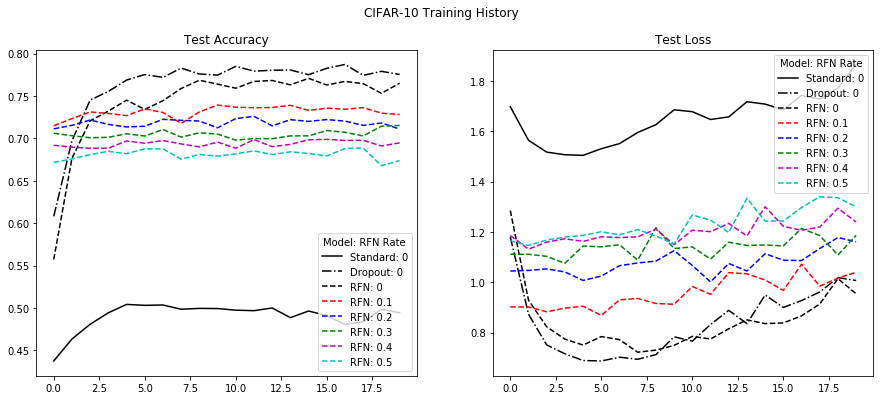

In [114]:
import matplotlib.pyplot as plt

colors = ['k', 'r', 'b', 'g', 'm', 'c']
linestyles = ['-', '-.', '--'] #Standard=solid, Dropout=dashdot, RFN=dash

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle('CIFAR-10 Training History')
ax[0].set_title('Test Accuracy')
ax[1].set_title('Test Loss')
for linestyle, model_name in zip(linestyles, models.keys()):
    for color, (mu, vals) in zip(colors, history[model_name].items()):
        try:
            acc, loss = vals
            ax[0].plot(range(len(acc)), acc, color+linestyle, label=f'{model_name}: {mu}')
            ax[1].plot(range(len(loss)), loss, color+linestyle, label=f'{model_name}: {mu}')
        except:
            continue
ax[0].legend(title='Model: RFN Rate')
ax[1].legend(title='Model: RFN Rate')

#### Evaluate Models with FSGM Samples

In [129]:
def fgsm_batch(net, orig, eps=15):
    '''Given a pytorch CNN model, original image as tensor, and value for epsilon, create adversarial sample
    using fast gradient sign method (FGSM) described in arXiv:1412.6572v3'''
    # Create input tensor from original image, unsqeezing by a dim to account for model expected batch dim
    # float cast is likely not needed after normalization, but as float is required for cuda execution,
    # it's best to ensure float data
    inp = orig.float().clone().detach().to(device).requires_grad_(True)
    
    # Make prediction prior to attack to use in calulating gradients
    prior_out = net(inp)
    prior_pred = prior_out.argmax(axis=1)
    
    # Use prediction vector to compute loss and then compute gradients from loss to use in attack
    #loss = criterion(prior_out, prior_pred.unsqueeze(0))
    criterion = nn.CrossEntropyLoss()
    loss = criterion(prior_out, prior_pred)
    loss.backward()
    
    # Actual FSGM method
    #print(orig.min(), orig.max())
    inp.data = inp.data + ((eps/255.0) * torch.sign(inp.grad.data))
    inp.data = inp.data.clamp(min=orig.min(), max=orig.max())
    #print(inp.min(), inp.max())
    '''
    # Predict on attack sample
    post_pred = torch.argmax(net(inp).data)
    
    # Create perturbation mask
    perturbation = torch.empty_like(orig)
    adv = inp.data.cpu()[0]
    perturbation = adv - orig'''
    
    return inp

In [125]:
def evaluate(net, dataloader, eps=15, adv=False):
    correct = 0
    count = 0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if adv:
            inputs = fgsm_batch(net, inputs, eps = eps)
        preds = net(inputs)
        for pred, label in zip(preds, labels):
            if torch.argmax(pred) == label:
                correct += 1.0
            count += 1.0
        if not i % 5000:
            print(f'Sample: {i}, Running Accuracy: {(correct/count):5.3f}')
    acc = correct/count
    print(f'Accuracy over {int(count)} samples: {acc:5.3f}')
    return acc

In [123]:
# Create accuracy dictionary
models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epsilons = [0, 40, 60, 90]

analysis = {}
for model_name in models.keys():
    analysis[model_name] = {}
    for mu in rfn_mu_vals:
        analysis[model_name][mu] = {}
        for eps in epsilons:
            analysis[model_name][mu][eps] = []

In [124]:
# Evaluate Standard, Dropout, and RFN CIFAR models with FGSM attack on validation data
'''val_dl = DataLoader(
    valset, batch_size=1, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)'''

models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epsilons = [0, 40, 60, 90]  # Corresponds to 0 .15, .25, and .35 in paper

# Evaluate pretrained CIFAR CNNs with and without FSGM attack, set sigma on RFN = 0 
for model_name, model_instance in models.items():
    print()
    for eps in epsilons:
        if eps == 0:
            adv = False
        else:
            adv = True
        for mu in rfn_mu_vals:
            if mu == 0:
                rfn_flag = False
            else:
                rfn_flag = True
            
            # Standard and Dropout models weren't trained with RFN
            if model_name != 'RFN' and mu != 0:
                print(f'Skip {model_name} at mu={mu}')
                continue

            model = model_instance
            # Set sigma to zero per paper
            rfn_wrapper = RFN(model, mu=mu, sigma=0, rfn_flag=rfn_flag)
            # Trained on Train data:
            model.load_state_dict(torch.load(f'./models/CIFAR_{model_name}_{mu}.pth'))
            
            # Trained on Full Train data:
            #model.load_state_dict(torch.load(f'./models/Full_CIFAR_{model_name}_{mu}.pth'))
            model.to(device)
            model.eval()
            criterion = nn.CrossEntropyLoss()

            print(f'Evaluate CIFAR {model_name}, eps={eps}, mu={mu}:')
            analysis[model_name][mu][eps] = evaluate(rfn_wrapper, val_dl, eps=eps, adv=adv)



Evaluate CIFAR Standard, eps=0, mu=0:
Sample: 0, Running Accuracy: 1.000
Sample: 5000, Running Accuracy: 0.546
Accuracy over 10000 samples: 0.550
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=40, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.322
Accuracy over 10000 samples: 0.325
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=60, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.325
Accuracy over 10000 samples: 0.322
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=90, mu=0:
Sample: 0, Running Accuracy: 0.000
Sample: 5000, Running Accuracy: 0.319
Accuracy over 10000 samples: 0.314
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip

In [126]:
import pickle
with open('./models/train20_cifar_analysis.pkl', 'wb') as f:
    pickle.dump(analysis, f)

with open('./models/train20_cifar_analysis.pkl', 'rb') as f:
    analysis = pickle.load(f)

In [127]:
print('Train/Valid CIFAR vs FGSM ')
print('\t\tFSGM Epsilons:')
print(f'MU  Model\t{0:<5}\t{40:<5}\t{60:<5}\t{90:<5}')
for model_name in models.keys():
    for mu in rfn_mu_vals:
        if model_name != 'RFN' and mu != 0:
            #print(f'Skip {model_name} at mu={mu}')
            continue
        print(f'{mu:<4}{model_name:<10}\t', end='')
        for eps in epsilons:
            print(f'{analysis[model_name][mu][eps]:.4}\t', end='')
        print()

Train/Valid CIFAR vs FGSM 
		FSGM Epsilons:
MU  Model	0    	40   	60   	90   
0   Standard  	0.5497	0.3248	0.3215	0.3139	
0   Dropout   	0.7622	0.3024	0.2612	0.2214	
0   RFN       	0.7543	0.3587	0.3198	0.2645	
0.1 RFN       	0.7318	0.3687	0.3491	0.3392	
0.2 RFN       	0.711	0.4166	0.3781	0.3553	
0.3 RFN       	0.7034	0.4573	0.4036	0.3598	
0.4 RFN       	0.6895	0.4997	0.4284	0.392	
0.5 RFN       	0.6668	0.5311	0.4633	0.3986	


In [130]:
# Evaluate Standard, Dropout, and RFN CIFAR models with FGSM attack on test data
'''val_dl = DataLoader(
    valset, batch_size=1, sampler=val_sampler,
    num_workers=num_workers, pin_memory=pin_memory)'''

models = {'Standard': CIFAR_Standard(), 'Dropout': CIFAR_Dropout(), 'RFN': CIFAR_RFN()}
rfn_mu_vals = [0, .1, .2, .3, .4, .5]
epsilons = [0, 40, 60, 90]  # Corresponds to 0 .15, .25, and .35 in paper

# Evaluate pretrained CIFAR CNNs with and without FSGM attack, set sigma on RFN = 0 
for model_name, model_instance in models.items():
    print()
    for eps in epsilons:
        if eps == 0:
            adv = False
        else:
            adv = True
        for mu in rfn_mu_vals:
            if mu == 0:
                rfn_flag = False
            else:
                rfn_flag = True
            
            # Standard and Dropout models weren't trained with RFN
            if model_name != 'RFN' and mu != 0:
                print(f'Skip {model_name} at mu={mu}')
                continue

            model = model_instance
            # Set sigma to zero per paper
            rfn_wrapper = RFN(model, mu=mu, sigma=0, rfn_flag=rfn_flag)
            # Trained on Train data:
            #model.load_state_dict(torch.load(f'./models/CIFAR_{model_name}_{mu}.pth'))
            
            # Trained on Full Train data:
            model.load_state_dict(torch.load(f'./models/Full_CIFAR_{model_name}_{mu}.pth'))
            model.to(device)
            model.eval()
            criterion = nn.CrossEntropyLoss()

            print(f'Evaluate CIFAR {model_name}, eps={eps}, mu={mu}:')
            analysis[model_name][mu][eps] = evaluate(rfn_wrapper, test_dl, eps=eps, adv=adv)


Evaluate CIFAR Standard, eps=0, mu=0:
Sample: 0, Running Accuracy: 0.547
Accuracy over 10000 samples: 0.494
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=40, mu=0:
Sample: 0, Running Accuracy: 0.375
Accuracy over 10000 samples: 0.311
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=60, mu=0:
Sample: 0, Running Accuracy: 0.344
Accuracy over 10000 samples: 0.307
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5
Evaluate CIFAR Standard, eps=90, mu=0:
Sample: 0, Running Accuracy: 0.344
Accuracy over 10000 samples: 0.304
Skip Standard at mu=0.1
Skip Standard at mu=0.2
Skip Standard at mu=0.3
Skip Standard at mu=0.4
Skip Standard at mu=0.5

Evaluate CIFAR Dropout, eps=0, mu=0:
Sample: 0, Running Accuracy: 0.828
Accuracy ov

In [131]:
import pickle
with open('./models/fulltrain20_cifar_analysis.pkl', 'wb') as f:
    pickle.dump(analysis, f)

with open('./models/fulltrain20_cifar_analysis.pkl', 'rb') as f:
    analysis = pickle.load(f)

In [132]:
print('FullTrain/Test CIFAR vs FGSM ')
print('\t\tFSGM Epsilons:')
print(f'MU  Model\t{0:<5}\t{40:<5}\t{60:<5}\t{90:<5}')
for model_name in models.keys():
    for mu in rfn_mu_vals:
        if model_name != 'RFN' and mu != 0:
            #print(f'Skip {model_name} at mu={mu}')
            continue
        print(f'{mu:<4}{model_name:<10}\t', end='')
        for eps in epsilons:
            print(f'{analysis[model_name][mu][eps]:.4}\t', end='')
        print()

FullTrain/Test CIFAR vs FGSM 
		FSGM Epsilons:
MU  Model	0    	40   	60   	90   
0   Standard  	0.4945	0.3107	0.3066	0.3041	
0   Dropout   	0.7754	0.2741	0.2361	0.1978	
0   RFN       	0.7651	0.2654	0.2332	0.1972	
0.1 RFN       	0.7274	0.3087	0.2685	0.2555	
0.2 RFN       	0.7129	0.3745	0.3207	0.2774	
0.3 RFN       	0.7148	0.4365	0.3544	0.3058	
0.4 RFN       	0.6931	0.4921	0.4018	0.327	
0.5 RFN       	0.6803	0.534	0.4561	0.3809	
